# Creating 5 Stratified K Fold cross validation sets

In [1]:
TRAINING_PATH='../input/titanic/train.csv'
TRAINING_FOLDS_PATH='./'

import pandas as pd

df_train=pd.read_csv(TRAINING_PATH)
df_train.head()

df_train['Survived'].value_counts()

df_train['kfolds']=-1
df_train=df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

from sklearn import model_selection

strat_kf=model_selection.StratifiedKFold(n_splits=5)

for fold,(trn_,val_) in enumerate(strat_kf.split(X=df_train,y=df_train['Survived'])):
  df_train.loc[val_,'kfolds']=fold
df_train.head()

df_train.to_csv(TRAINING_FOLDS_PATH+'train_folds.csv')


# Importing Libraries

In [2]:
import joblib
import pandas as pd
from sklearn import metrics
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# File Paths

In [3]:
TRAINING_PATH='./train_folds.csv'
TESTING_PATH='../input/titanic/test.csv'
MODEL_PATH='./'
SUBMISSION_FILES_PATH='./Submissions/'

# Data Exploration

1.   Null Values
2.   Number of unique values



In [4]:
df=pd.read_csv(TRAINING_PATH)
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,kfolds
0,0,409,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,312992,7.7750,NaN,S,0
1,1,207,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,NaN,S,0
2,2,617,0,3,"Danbom, Mr. Ernst Gilbert",male,34.0,1,1,347080,14.4000,NaN,S,0
3,3,822,1,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.6625,NaN,S,0
4,4,247,0,3,"Lindahl, Miss. Agda Thorilda Viktoria",female,25.0,0,0,347071,7.7750,NaN,S,0


In [5]:
df.describe()

,Unnamed: 0,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,kfolds
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.997755
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.415800
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,445.000000,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,667.500000,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,3.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,4.000000


In [6]:
# Count the number of null values in each column
df.isna().sum()

Unnamed: 0       0
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
kfolds           0
dtype: int64

In [7]:
# Total number of rows
len(df)

891

In [8]:
# Total number of unique values in each column
df.nunique()

Unnamed: 0     891
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
kfolds           5
dtype: int64

In [9]:
# Check for class imbalance 
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Drop Columns based on the number of unique values and number of null values (both should be sufficiently large to drop) 

In [10]:
# Unnamed:0 , Name and PassengerId have all different values so no value can determine the result
# Ticket also has lots of different values
# Cabin has lots of null values
df=df.drop(['Cabin','Name','PassengerId','Unnamed: 0','Ticket'],axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,kfolds
0,0,3,male,21.0,0,0,7.7750,S,0
1,0,3,male,32.0,1,0,15.8500,S,0
2,0,3,male,34.0,1,1,14.4000,S,0
3,1,3,male,27.0,0,0,8.6625,S,0
4,0,3,female,25.0,0,0,7.7750,S,0


#### Imputer to fill in missing values

1.   KNN Imputer
2.   Iterative Imputer



In [11]:
# Use KNN Imputer to fill missing values

from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=3)

df_knn_imputed=df
df_knn_imputed['Age']=imputer.fit_transform(df_knn_imputed['Age'].values.reshape(-1,1))
df_knn_imputed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,kfolds
0,0,3,male,21.0,0,0,7.7750,S,0
1,0,3,male,32.0,1,0,15.8500,S,0
2,0,3,male,34.0,1,1,14.4000,S,0
3,1,3,male,27.0,0,0,8.6625,S,0
4,0,3,female,25.0,0,0,7.7750,S,0


In [12]:
# Use Iterative Imputer to fill missing values

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
imputer=IterativeImputer(random_state=42)

df_iter_imputed=df
df_iter_imputed['Age']=imputer.fit_transform(df_iter_imputed['Age'].values.reshape(-1,1))
df_iter_imputed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,kfolds
0,0,3,male,21.0,0,0,7.7750,S,0
1,0,3,male,32.0,1,0,15.8500,S,0
2,0,3,male,34.0,1,1,14.4000,S,0
3,1,3,male,27.0,0,0,8.6625,S,0
4,0,3,female,25.0,0,0,7.7750,S,0


#### One hot encode categorical features

In [13]:
# One hot encode the categorical columns - Sex and Embarked

df=pd.get_dummies(data=df_iter_imputed,columns=['Sex','Embarked'])
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,kfolds,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,21.0,0,0,7.7750,0,0,1,0,0,1
1,0,3,32.0,1,0,15.8500,0,0,1,0,0,1
2,0,3,34.0,1,1,14.4000,0,0,1,0,0,1
3,1,3,27.0,0,0,8.6625,0,0,1,0,0,1
4,0,3,25.0,0,0,7.7750,0,1,0,0,0,1


#### Move the Survived and kfolds column to the end

In [14]:
# Move the target and kfolds column to the last

df=df[[column for column in df if column not in['Survived','kfolds']]+['Survived','kfolds']]
df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived,kfolds
0,3,21.0,0,0,7.7750,0,1,0,0,1,0,0
1,3,32.0,1,0,15.8500,0,1,0,0,1,0,0
2,3,34.0,1,1,14.4000,0,1,0,0,1,0,0
3,3,27.0,0,0,8.6625,0,1,0,0,1,1,0
4,3,25.0,0,0,7.7750,1,0,0,0,1,0,0


#### MinMax Scaler

In [15]:
# Scale the columns using MinMaxScaler except for the target and kfolds column

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_2=pd.DataFrame(scaler.fit_transform(df),index=df.index,columns=df.columns)
df_2['kfolds']=df['kfolds']
df_2['Survived']=df['Survived']
df=df_2
df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived,kfolds
0,1.0,0.258608,0.000,0.000000,0.015176,0.0,1.0,0.0,0.0,1.0,0,0
1,1.0,0.396833,0.125,0.000000,0.030937,0.0,1.0,0.0,0.0,1.0,0,0
2,1.0,0.421965,0.125,0.166667,0.028107,0.0,1.0,0.0,0.0,1.0,0,0
3,1.0,0.334004,0.000,0.000000,0.016908,0.0,1.0,0.0,0.0,1.0,1,0
4,1.0,0.308872,0.000,0.000000,0.015176,1.0,0.0,0.0,0.0,1.0,0,0


# Feature Selection

1.   Greedy Feature Selection
2.   Recursive Feature Selection



In [16]:
def run(fold,df,models,target_name, save_model, print_details=False):
  
  # print(df.head())
  # Training and validation sets
  df_train=df[df['kfolds']!=fold].reset_index(drop=True)
  df_valid=df[df['kfolds']==fold].reset_index(drop=True)


  # x and y of training dataset
  x_train=df_train.drop(target_name,axis=1).values
  y_train=df_train[target_name].values

  # x and y of validation dataset
  x_valid=df_valid.drop(target_name,axis=1).values
  y_valid=df_valid[target_name].values

  # accuracy => will store accuracies of the models  (same for confusion_matrices)
  accuracy=[]
  confusion_matrices=[]
  classification_report=[]

  for model_name,model_constructor in list(models.items()):
    clf=model_constructor
    clf.fit(x_train,y_train)

    # preds_train, preds_valid => predictions when training and validation x are fed into the trained model
    preds_train=clf.predict(x_train)
    preds_valid=clf.predict(x_valid)

    acc_train=metrics.accuracy_score(y_train,preds_train)
    acc_valid=metrics.accuracy_score(y_valid,preds_valid)

    f1_train = metrics.f1_score(y_train,preds_train)
    f1_valid = metrics.f1_score(y_valid,preds_valid)

    conf_matrix=metrics.confusion_matrix(y_valid,preds_valid)
    class_report=metrics.classification_report(y_valid,preds_valid)

    accuracy.append(acc_valid)
    confusion_matrices.append(conf_matrix)
    classification_report.append(class_report)

    if(print_details==True):
      print(f'Model => {model_name} => Fold = {fold} => Training Accuracy = {acc_train} => Validation Accuracy = {acc_valid}')

    if(save_model==True):
      joblib.dump(clf, f"{MODEL_PATH}{model_name}_F1_{f1_valid}_ACC_{acc_valid}_FOLD_{fold}.bin")

  if(print_details==True):
    print('\n--------------------------------------------------------------------------------------------\n')
    
  return accuracy,confusion_matrices,classification_report

In [17]:
def greedy_feature_selection(fold,df,models,target_name):

  # target_index => stores the index of the target variable in the dataset
  # kfolds_index => stores the index of kfolds column in the dataset

  target_index=df.columns.get_loc(target_name)
  kfolds_index=df.columns.get_loc('kfolds')

  # good_features => stores the indices of all the optimal features
  # best_scores => keeps track of the best scores 
  good_features=[]
  best_scores=[]

  # df has X and y and a kfolds column. 
  # no of features (no of columns in X) => total columns in df - 1 (there's 1 y) - 1 (there's 1 kfolds)
  num_features=df.shape[1]-2

  while True:

    # this_feature => the feature added to the already selected features to measure the effect of the former on the model
    # best_score => keeps track of the best score achieved while selecting features 1 at a time and checking its effect on the model
    this_feature=None
    best_score=0


    for feature in range(num_features):

      # if the feature is already in the good_features list, ignore and move ahead
      if feature in good_features:
        continue
      
      # add the currently selected feature to the already discovered good features
      selected_features=good_features+[feature]

      # all the selected features + target and kfolds column
      df_train=df.iloc[:, selected_features + [target_index,kfolds_index]]

      # fit the selected dataset to a model 
      accuracy,confusion_matrices,classification_report=run(fold,df_train,models,save_model= False, target_name=target_name)

      # if any improvement is observed over the previous set of features
      if(accuracy[0]>best_score):
        this_feature=feature
        best_score=accuracy[0]
      
    if(this_feature!=None):
      good_features.append(this_feature)
      best_scores.append(best_score)
    
    if(len(best_scores)>2):
      if(best_scores[-1]<best_scores[-2]):
        break
    
  return best_scores[:-1] , df.iloc[:, good_features[:-1] + [target_index,kfolds_index]]

In [18]:
from sklearn.feature_selection import RFE

def recursive_feature_selection(df,models,n_features_to_select,target_name):
  X=df.drop(labels=[target_name,'kfolds'],axis=1).values
  y=df[target_name]
  kfolds=df.kfolds.values

  model_name,model_constructor=list(models.items())[0]

  rfe=RFE(
      estimator=model_constructor,
      n_features_to_select=n_features_to_select
  )

  try:
    rfe.fit(X,y)
  except :
    print(f"{model_name} does not support feature importance... Returning original dataframe\n")
    return df
  else:
    X_transformed = rfe.transform(X)
    df_optimal=pd.DataFrame(data=[X,y,kfolds])
    return df_optimal

# Finding the optimal features for the different models

Models :

1.   XGB Classifier
2.   SVM Classifier
3.   Random Forest Classifier



### XGB (Both Greedy and Recursive Feature Selection Techniques work!)

In [19]:
print('Greedy Feature Selection : ')
print('\n')
models={'XGB': XGBClassifier()}
best_scores,df_optimal_XGB=greedy_feature_selection(fold=4,df=df,models=models,target_name='Survived')
print(df_optimal_XGB.head())

print('\n')
print("Recursive Feature Selection : ")
print('\n')
df_recursive_optimal_XGB=recursive_feature_selection(df=df,models=models,n_features_to_select=5,target_name='Survived')
print(df_recursive_optimal_XGB.head())

Greedy Feature Selection : 


[19:12:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:12:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:12:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:12:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if yo

### SVM (Only Greedy Feature Selection works!)

In [20]:
models={'SVM' : SVC()}
best_scores,df_optimal_SVM=greedy_feature_selection(fold=4,df=df,models=models,target_name='Survived')
print(df_optimal_SVM.head())

print('\n')
df_recursive_optimal_SVM=recursive_feature_selection(df=df,models=models,n_features_to_select=5,target_name='Survived')
print(df_recursive_optimal_SVM.head())

   Sex_female  Pclass  SibSp       Age     Parch  Sex_male  Embarked_S  \
0         0.0     1.0  0.000  0.258608  0.000000       1.0         1.0   
1         0.0     1.0  0.125  0.396833  0.000000       1.0         1.0   
2         0.0     1.0  0.125  0.421965  0.166667       1.0         1.0   
3         0.0     1.0  0.000  0.334004  0.000000       1.0         1.0   
4         1.0     1.0  0.000  0.308872  0.000000       0.0         1.0   

   Survived  kfolds  
0         0       0  
1         0       0  
2         0       0  
3         1       0  
4         0       0  


SVM does not support feature importance... Returning original dataframe

   Pclass       Age  SibSp     Parch      Fare  Sex_female  Sex_male  \
0     1.0  0.258608  0.000  0.000000  0.015176         0.0       1.0   
1     1.0  0.396833  0.125  0.000000  0.030937         0.0       1.0   
2     1.0  0.421965  0.125  0.166667  0.028107         0.0       1.0   
3     1.0  0.334004  0.000  0.000000  0.016908         0.0  

### Random Forest (Both Greedy and Recursive Feature Selection work!)

In [21]:
models={'RFC' : RandomForestClassifier()}
best_scores,df_optimal_RFC=greedy_feature_selection(fold=4,df=df,models=models,target_name='Survived')
print(df_optimal_RFC.head())

print('\n')
df_recursive_optimal_RFC=recursive_feature_selection(df=df,models=models,n_features_to_select=5,target_name='Survived')
print(df_recursive_optimal_RFC.head())

   Sex_female  SibSp  Pclass      Fare       Age  Embarked_S  Sex_male  \
0         0.0  0.000     1.0  0.015176  0.258608         1.0       1.0   
1         0.0  0.125     1.0  0.030937  0.396833         1.0       1.0   
2         0.0  0.125     1.0  0.028107  0.421965         1.0       1.0   
3         0.0  0.000     1.0  0.016908  0.334004         1.0       1.0   
4         1.0  0.000     1.0  0.015176  0.308872         1.0       0.0   

   Embarked_C  Survived  kfolds  
0         0.0         0       0  
1         0.0         0       0  
2         0.0         0       0  
3         0.0         1       0  
4         0.0         0       0  


                                                   0
0  [[1.0, 0.2586076903744659, 0.0, 0.0, 0.0151757...
1  0      0
1      0
2      0
3      1
4      0
 ...
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


# **Warning : These cells take hours to run! So Uncomment the lines if you want to run it. The output for the commented codes are given below**

---


# Hyperparameter tuning

Models : 

1.   XGB Classifier
2.   SVM Classifier
3.   Random Forest Classifier




In [22]:
from sklearn import model_selection
from sklearn import metrics

def hyperparameter_tune_and_run(df,num_folds,models,target_name,param_grid,evaluation_metric,print_details=False):
  X=df.drop(labels=[target_name,'kfolds'],axis=1).values
  y=df[target_name]

  model_name,model_constructor=list(models.items())[0]

  model = model_selection.GridSearchCV(
      estimator = model_constructor,
      param_grid = param_grid,
      scoring = evaluation_metric,
      verbose = 10,
      cv = num_folds,
      n_jobs=-1
  )

  model.fit(X,y)

  if(print_details==True):
    print(f"Best score : {model.best_score_}")

    print("Best parameters : ")
    best_parameters=model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
      print(f"\t{param_name}: {best_parameters[param_name]}")
  
  return model

### Hyperparameter Tune for XGB : 


In [23]:
# models={'XGB Classifier': XGBClassifier()}
# param_grid = {
#     "learning_rate":[0.01,0.015,0.025,0.05,0.1],
#     "gamma":[0.05,0.1,0.3,0.5,0.7,0.9,1.0],
#     "max_depth":[3,5,7,9,12,15,17,25],
#     "min_child_weight":[1,3,5,7],
#     "subsample":[0.6,0.7,0.8,0.9,1.0],
#     "colsample_bytree":[0.6,0.7,0.8,0.9,1.0],
#     # "reg_lambda":[0.01,0.03,0.05,0.07,0.09,0.1,1.0],
#     # "reg_alpha":[0.01,0.03,0.05,0.07,0.09,0.1,1.0]
# }
# model = hyperparameter_tune_and_run(df=df_optimal_XGB,num_folds=5,models=models,target_name='Survived',param_grid=param_grid,evaluation_metric="accuracy",print_details=True)

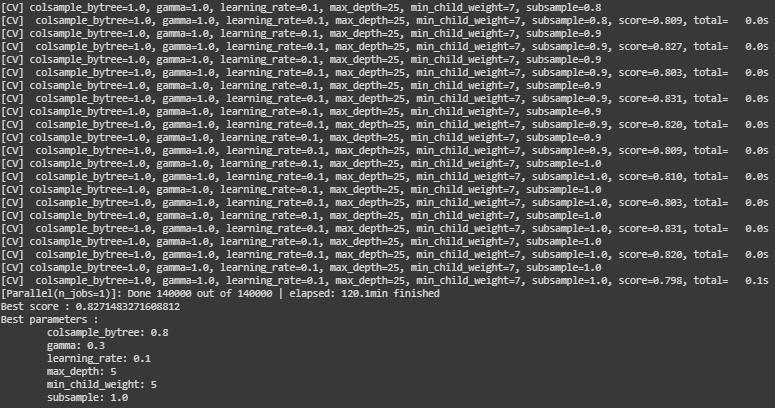

Best score : 0.8271483271608812<br>
Best parameters : <br>
	colsample_bytree: 0.8 <br>
	gamma: 0.3 <br>
	learning_rate: 0.1 <br>
	max_depth: 5 <br>
	min_child_weight: 5 <br>
	subsample: 1.0 <br>

In [24]:
# models={'SVM Classifier': SVC()}
# param_grid = {
#     "C":[0.001,0.01,0.1,1,10,100,1000],
#     "gamma":['auto'],
#     "class_weight":['balanced']
# }
# SVM_model = hyperparameter_tune_and_run(df=df_optimal_SVM,num_folds=5,models=models,target_name='Survived',param_grid=param_grid,evaluation_metric="accuracy",print_details=True)

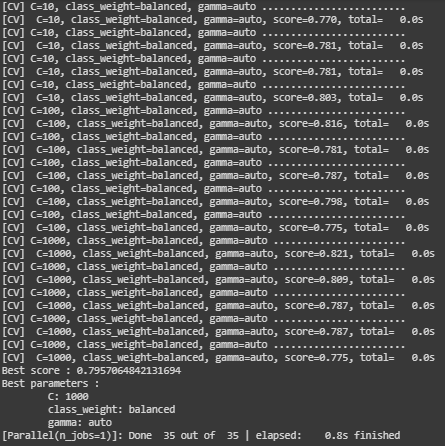

Best score : 0.7957064842131694 <br>
Best parameters : <br>
	C: 1000 <br>
	class_weight: balanced <br>
	gamma: auto <br>

In [25]:
# models={'Random Forest': RandomForestClassifier()}
# param_grid = {
#     "n_estimators":[120,300,500,800,1200],
#     "max_depth":[5,8,15,25,30,None],
#     "min_samples_split":[1,2,5,10,15,100],
#     "min_samples_leaf":[1,2,5,10],
#     "max_features":["log2","sqrt",None]
# }
# Random_Forest_model = hyperparameter_tune_and_run(df=df_optimal_RFC,num_folds=5,models=models,target_name='Survived',param_grid=param_grid,evaluation_metric="accuracy",print_details=True)

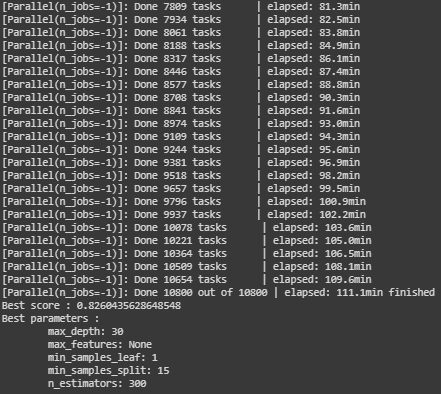

Best score : 0.8260435628648548 <br>
Best parameters : <br>
	max_depth: 30 <br>
	max_features: None <br>
	min_samples_leaf: 1 <br>
	min_samples_split: 15 <br>
	n_estimators: 300 <br>

# Run the models

### Initialise XGB, SVC, Random Forest with their best hyperparameters

In [26]:
XGB_model=XGBClassifier(max_depth=4,learning_rate=0.1,colsample_bytree=0.8,gamma=0.3,min_child_weight=5,subsample=1.0)
SVM_model=SVC(C=1000,class_weight='balanced',gamma='auto')
RFC_model=RandomForestClassifier(max_depth=30,max_features=None,min_samples_leaf=1,min_samples_split=15,n_estimators=300)

models={
    'XGB Classifier' : XGB_model,
    'SVM Classifier' : SVM_model,
    'Random Forest Classifier' : RFC_model
    }


### 1. Fitting the models on the dataset with features optimal to XGB ie. the dataframe we obtained after feature selection on XGB

In [27]:
accuracies,confusion_matrices,classification_reports=[],[],[]
for f in range(5):
  accuracy,confusion_matrix,classification_report=run(f,df_optimal_XGB,models=models,target_name='Survived', save_model= True, print_details=True)
  accuracies.append(accuracy)
  confusion_matrices.append(confusion_matrix)
  classification_reports.append(classification_report)

[19:12:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model => XGB Classifier => Fold = 0 => Training Accuracy = 0.851123595505618 => Validation Accuracy = 0.776536312849162
Model => SVM Classifier => Fold = 0 => Training Accuracy = 0.8146067415730337 => Validation Accuracy = 0.7374301675977654
Model => Random Forest Classifier => Fold = 0 => Training Accuracy = 0.8820224719101124 => Validation Accuracy = 0.7988826815642458

--------------------------------------------------------------------------------------------

[19:12:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model => XGB Classifier => 

### 2. Fitting the models on the dataset with features optimal to SVM ie. the dataframe we obtained after feature selection on SVM

In [28]:
XGB_model=XGBClassifier(max_depth=4,learning_rate=0.1,colsample_bytree=0.8,gamma=0.3,min_child_weight=5,subsample=1.0)
SVM_model=SVC(C=1000,class_weight='balanced',gamma='auto')
RFC_model=RandomForestClassifier(max_depth=30,max_features=None,min_samples_leaf=1,min_samples_split=15,n_estimators=300)

models={
    'XGB Classifier' : XGB_model,
    'SVM Classifier' : SVM_model,
    'Random Forest Classifier' : RFC_model
    }

accuracies,confusion_matrices,classification_reports=[],[],[]
for f in range(5):
  accuracy,confusion_matrix,classification_report=run(f,df_optimal_SVM,models=models,target_name='Survived', save_model= True, print_details=True)
  accuracies.append(accuracy)
  confusion_matrices.append(confusion_matrix)
  classification_reports.append(classification_report)

[19:12:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model => XGB Classifier => Fold = 0 => Training Accuracy = 0.8721910112359551 => Validation Accuracy = 0.8156424581005587
Model => SVM Classifier => Fold = 0 => Training Accuracy = 0.8455056179775281 => Validation Accuracy = 0.7094972067039106
Model => Random Forest Classifier => Fold = 0 => Training Accuracy = 0.8778089887640449 => Validation Accuracy = 0.8268156424581006

--------------------------------------------------------------------------------------------

[19:12:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model => XGB Classifier =

### 3. Fitting the models on the dataset with features optimal to Random Forest Classifier (RFC) ie. the dataframe we obtained after feature selection on RFC

In [29]:
XGB_model=XGBClassifier(max_depth=4,learning_rate=0.1,colsample_bytree=0.8,gamma=0.3,min_child_weight=5,subsample=1.0)
SVM_model=SVC(C=1000,class_weight='balanced',gamma='auto')
RFC_model=RandomForestClassifier(max_depth=30,max_features=None,min_samples_leaf=1,min_samples_split=15,n_estimators=300)

models={
    'XGB Classifier' : XGB_model,
    'SVM Classifier' : SVM_model,
    'Random Forest Classifier' : RFC_model
    }

accuracies,confusion_matrices,classification_reports=[],[],[]
for f in range(5):
  accuracy,confusion_matrix,classification_report=run(f,df_optimal_RFC,models=models,target_name='Survived', save_model= True, print_details=True)
  accuracies.append(accuracy)
  confusion_matrices.append(confusion_matrix)
  classification_reports.append(classification_report)

[19:12:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model => XGB Classifier => Fold = 0 => Training Accuracy = 0.8918539325842697 => Validation Accuracy = 0.8044692737430168
Model => SVM Classifier => Fold = 0 => Training Accuracy = 0.851123595505618 => Validation Accuracy = 0.6201117318435754
Model => Random Forest Classifier => Fold = 0 => Training Accuracy = 0.9002808988764045 => Validation Accuracy = 0.8324022346368715

--------------------------------------------------------------------------------------------

[19:12:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model => XGB Classifier =>

# Conclusion : Overall, XGB and Random Forest seem to have comparable accuracies but in 1-2 cases, Random Forest Classifier had a bit better accuracy among the two. So Random Forest seemed best for this

# Prediction

In [30]:
df_test = pd.read_csv(TESTING_PATH)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [31]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### Creating the dataframe to submit and inserting the Passenger ID column



In [32]:
df_submit=pd.DataFrame()
df_submit['PassengerId']=df_test['PassengerId']
df_submit.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


### Perform similar preprocessing on the test dataframe and use the same features in the test df as those in the train dataframe optimal for RFC

In [33]:
df_optimal_RFC.head()

,Sex_female,SibSp,Pclass,Fare,Age,Embarked_S,Sex_male,Embarked_C,Survived,kfolds
0,0.0,0.000,1.0,0.015176,0.258608,1.0,1.0,0.0,0,0
1,0.0,0.125,1.0,0.030937,0.396833,1.0,1.0,0.0,0,0
2,0.0,0.125,1.0,0.028107,0.421965,1.0,1.0,0.0,0,0
3,0.0,0.000,1.0,0.016908,0.334004,1.0,1.0,0.0,1,0
4,1.0,0.000,1.0,0.015176,0.308872,1.0,0.0,0.0,0,0


In [34]:
def get_preprocessed_test_data(df,df_test):
    


  df_test=pd.get_dummies(data=df_test,columns=['Sex','Embarked'])

  optimal_data_cols = df.columns
  optimal_data_cols = list(optimal_data_cols[:-2])
  df_test=df_test.loc[:,optimal_data_cols]

  null_columns = [k for k,v in dict(df_test.isna().sum()).items() if v!=0]

  for null_column in null_columns:
    df_test[null_column]=imputer.transform(df_test[null_column].values.reshape(-1,1))

  df_test_2=pd.DataFrame(scaler.fit_transform(df_test),index=df_test.index,columns=df_test.columns)
  df_test=df_test_2

  return df_test

In [35]:
df_test = get_preprocessed_test_data(df_optimal_RFC,df_test)
df_test.head()

,Sex_female,SibSp,Pclass,Fare,Age,Embarked_S,Sex_male,Embarked_C
0,0.0,0.000,1.0,0.015282,0.452723,0.0,1.0,0.0
1,1.0,0.125,1.0,0.013663,0.617566,1.0,0.0,0.0
2,0.0,0.000,0.5,0.018909,0.815377,0.0,1.0,0.0
3,0.0,0.000,1.0,0.016908,0.353818,1.0,1.0,0.0
4,1.0,0.125,1.0,0.023984,0.287881,1.0,0.0,0.0


In [36]:
df_test.isna().sum()

Sex_female    0
SibSp         0
Pclass        0
Fare          0
Age           0
Embarked_S    0
Sex_male      0
Embarked_C    0
dtype: int64

### Just re-train the RFC model once again!

In [37]:
x_train=df_optimal_RFC.drop(['Survived','kfolds'],axis=1)
y_train=df_optimal_RFC['Survived']

In [38]:
x_train.head()

,Sex_female,SibSp,Pclass,Fare,Age,Embarked_S,Sex_male,Embarked_C
0,0.0,0.000,1.0,0.015176,0.258608,1.0,1.0,0.0
1,0.0,0.125,1.0,0.030937,0.396833,1.0,1.0,0.0
2,0.0,0.125,1.0,0.028107,0.421965,1.0,1.0,0.0
3,0.0,0.000,1.0,0.016908,0.334004,1.0,1.0,0.0
4,1.0,0.000,1.0,0.015176,0.308872,1.0,0.0,0.0


In [39]:
len(x_train)

891

In [40]:
final_model = RandomForestClassifier(max_depth=30,max_features=None,min_samples_leaf=1,min_samples_split=15,n_estimators=300)
final_model.fit(x_train,y_train)

RandomForestClassifier(max_depth=30, max_features=None, min_samples_split=15,
                       n_estimators=300)

In [41]:
joblib.dump(final_model, f"{MODEL_PATH}Final Random Forest Classifier Model.bin")

['./Final Random Forest Classifier Model.bin']

In [42]:
df_submit['Survived']=final_model.predict(df_test)

In [43]:
df_submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [44]:
len(df_submit)

418

In [45]:
df_submit.to_csv('RFC_Submission_Allfeats_hyperparams_tuned_100.csv',index=False)